In [1]:
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

from openai import OpenAI

# Nebius uses the same OpenAI() class, but with additional details
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# llm_model = ""
'''
Step 1: I choose my LLM to run this case. Using 3 models
'''
llm_models = [
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "Qwen/Qwen2.5-32B-Instruct"
]

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.

    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """

    output_lines = []
    lines = text.split("\n") #Split the chunk of text retrieved from LLM into lines
    for line in lines:       #Loop all the lines
        current_line = ""
        words = line.split() #Split the lines into words separate by whitespace
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def answer_with_llm(prompt: str,
                    system_prompt,
                    max_tokens=512,
                    client=nebius_client,
                    model=llm_models,
                    prettify=False,
                    temperature=0.7) -> str:

    messages = []
    #print("\nModel Type: "+model+"\n")

    if system_prompt:
        messages.append(
            {
                "role": "system",
                "content": system_prompt
            }
        )

    messages.append(
        {
            "role": "user",
            "content": prompt
        }
    )

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature
    )
    if prettify:
        return prettify_string(completion.choices[0].message.content)
    else:
        return completion.choices[0].message.content

In [2]:
#To find the log Probability of the suggestions after my prompt

def answer_with_logprobs(prompt: str,
                         system_prompt="You are a helpful assistant",
                         max_tokens=512,
                         client=nebius_client,
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         temperature=0.6):
    # Adapt to your logprobs extraction logic as needed
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        logprobs=True,
        top_logprobs=5,
    
    )
    print("\n"),
    print(completion.choices[0].message.content)
    return completion

In [3]:
'''
Step 2: Define my prompts for this exercise
Using 2 temperatures
Each promt will run 20 times (n_trails) to temp 0.6 first follow by 1 (temperatures)

'''
system_prompt="You are a helpful assistant"

prompts = {
    "Name": "Suggest a name for a Disney cartoon character. Only output the name.",
    "Occupation": "Suggest an occupation for a Disney cartoon character. Only output the name of the occupation.",
    "Hobby": "Suggest a hobby for a Disney cartoon character. Only output the name of the hobby."
}
'''
For each model and prompt, count how many unique answers I get. 
Question 1: Are certain names/occupations always being repeated?
Question 2: Does the model have “favorites” it repeats a lot?
'''

n_trials = 20
temperatures = [0.6, 1.0]

all_results = {} #Creates an empty dictionary called results.

for model in llm_models:
    all_results[model] = {} #For each model, adds a new dictionary
    for temp in temperatures:
        all_results[model][temp] = {} #For each temperature set up another dictionary layer to keep results separate for each temperature.
        print(f"\nRunning model: {model} | temperature: {temp}\n")
        for prompt_type, prompt in prompts.items(): #Loop through each prompt
            answers = [] #empty list called answers to store the LLM’s responses for that prompt
            for _ in tqdm(range(n_trials), desc=f"{prompt_type} (T={temp})"):
                response = answer_with_llm(
                    system_prompt=system_prompt,
                    prompt=prompt,
                    model=model,
                    temperature=temp
                )
                answers.append(response.strip()) #Store the returned (and stripped) response in answers variable.
            all_results[model][temp][prompt_type] = answers #save the list of responses under each model, temperature, and prompt type in all_results

'''
analyzes and prints how often each answer appears for every model, temperature, and prompt type
To see if some names/occupations/hobbies are being repeated a lot or if there is good variety
'''
print("\n==== Diversity Counts ====\n")
for model in all_results:
    for temp in temperatures:
        for prompt_type in prompts:
            responses = all_results[model][temp][prompt_type]
            counts = Counter(responses)
            print(f"Model: {model} | Temperature: {temp} | Prompt: {prompt_type}")
            print(counts)
            print("-" * 40)


Running model: meta-llama/Meta-Llama-3.1-8B-Instruct | temperature: 0.6



Hobby (T=0.6): 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]



Running model: meta-llama/Meta-Llama-3.1-8B-Instruct | temperature: 1.0



Hobby (T=1.0): 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]



Running model: meta-llama/Meta-Llama-3.1-70B-Instruct | temperature: 0.6



Hobby (T=0.6): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]



Running model: meta-llama/Meta-Llama-3.1-70B-Instruct | temperature: 1.0



Hobby (T=1.0): 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]



Running model: Qwen/Qwen2.5-32B-Instruct | temperature: 0.6



Hobby (T=0.6): 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]



Running model: Qwen/Qwen2.5-32B-Instruct | temperature: 1.0



Hobby (T=1.0): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


==== Diversity Counts ====

Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Temperature: 0.6 | Prompt: Name
Counter({'Luna Sparklesong': 5, 'Luna Sparklewing': 3, 'Lumina Sparkspanner': 2, 'Lunaria Starweaver': 2, 'Lunaria Sparkspanner': 1, 'Luna Sparkwing': 1, 'Lunabell': 1, 'Lumina Sparkleberry': 1, 'Zuzu Bloom': 1, 'Lunabelle': 1, 'Lumina Starweaver': 1, 'Lunabloom': 1})
----------------------------------------
Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Temperature: 0.6 | Prompt: Occupation
Counter({'Park Ranger': 2, 'Toymaker': 2, 'Circus Ringmaster': 2, 'Circus Clown': 1, 'Tour Guide': 1, "Cartographer to the Kingdom's Explorers Guild": 1, 'Galactic Tour Guide': 1, 'Parks Engineer': 1, 'Ice Cream Cart Vendor': 1, 'Cartographer': 1, 'Librarian': 1, 'Bakery Owner': 1, "Magician's Apprentice": 1, "Librarian at the Beast's castle library.": 1, 'Master Baker': 1, 'Jungle Explorer': 1, 'Pirate Bookbinder': 1})
----------------------------------------
Model: meta-llama/Meta-Llama-3.1

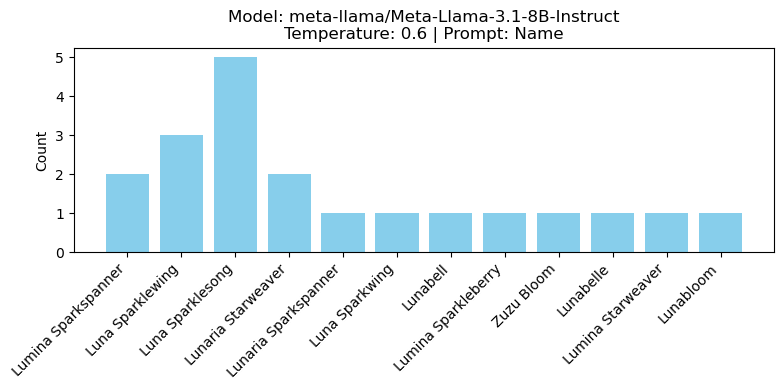

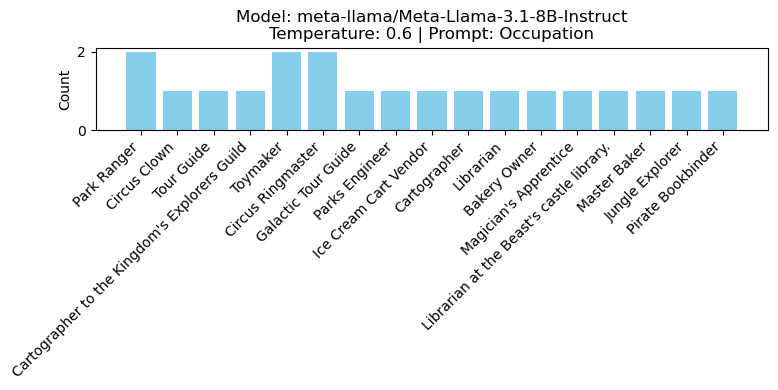

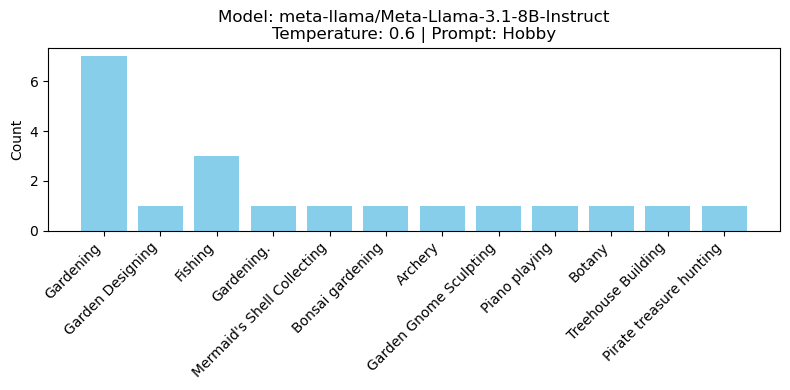

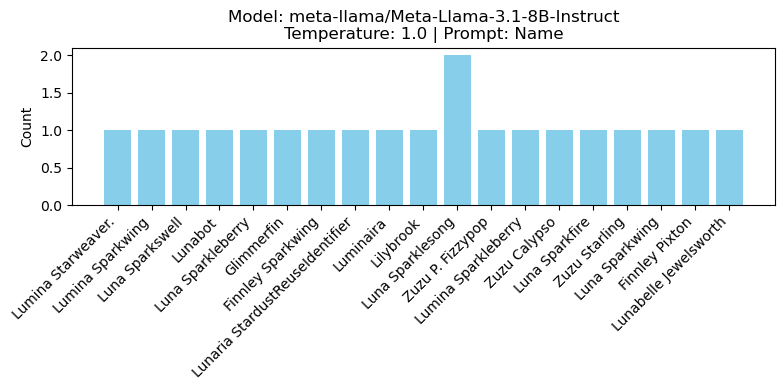

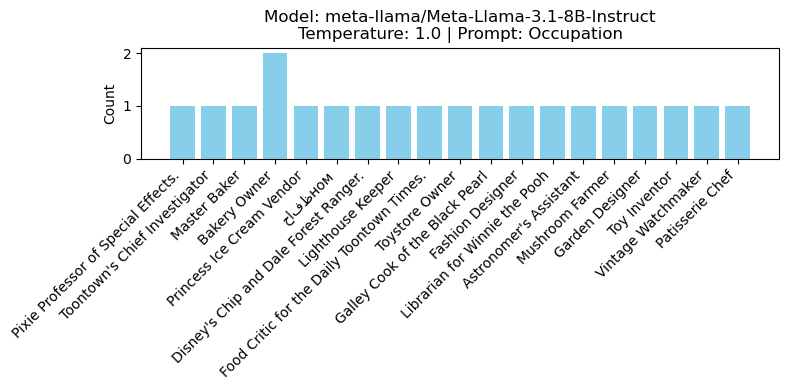

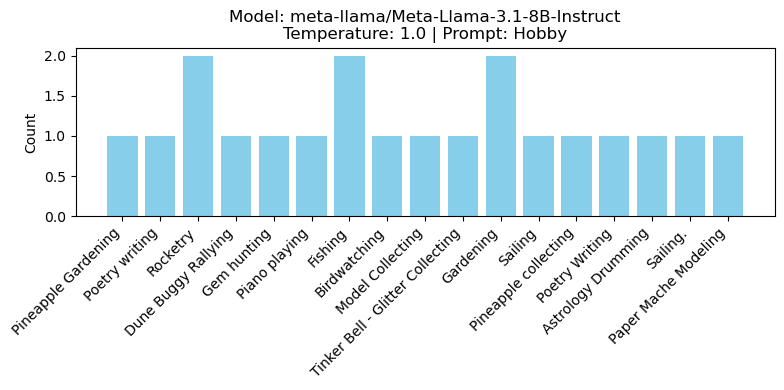

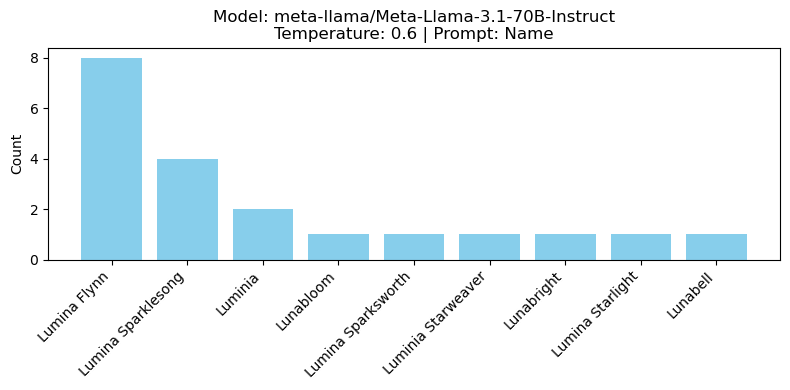

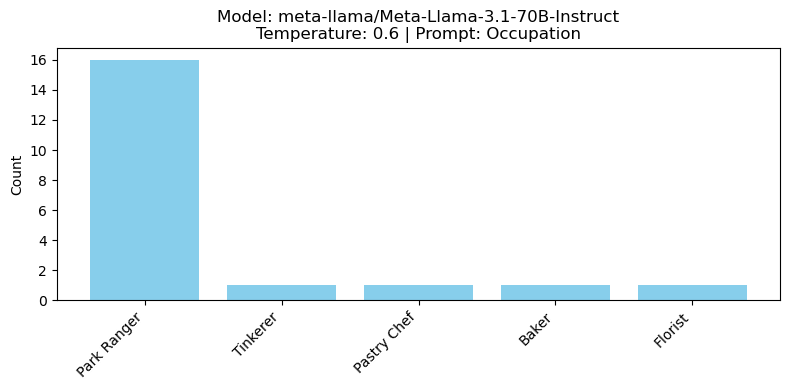

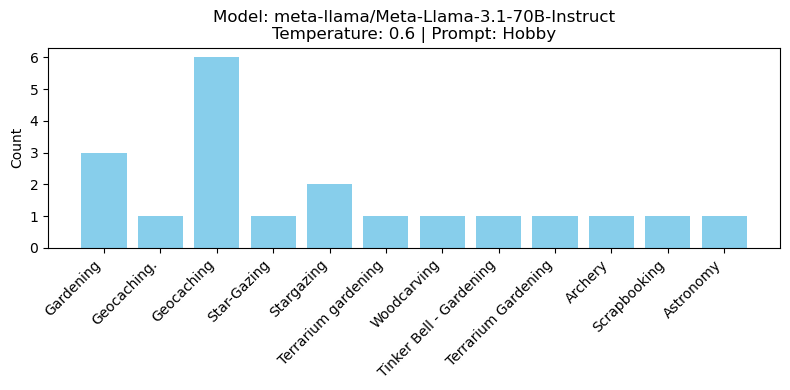

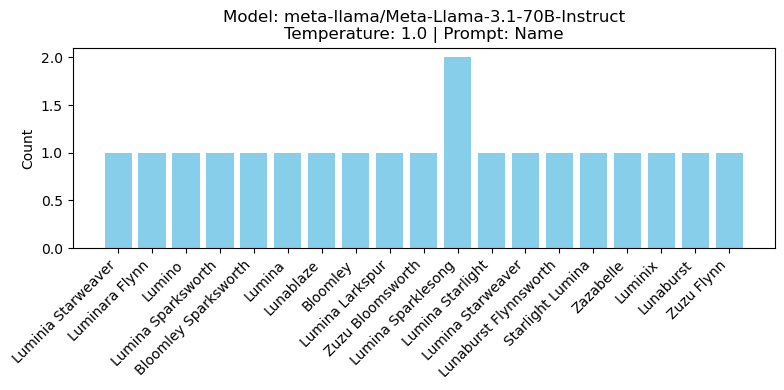

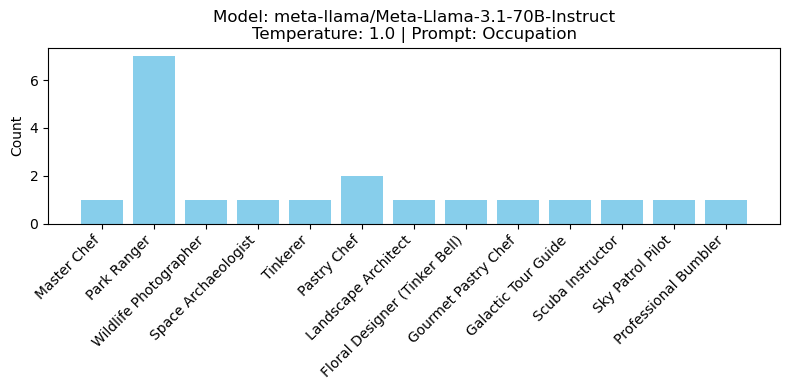

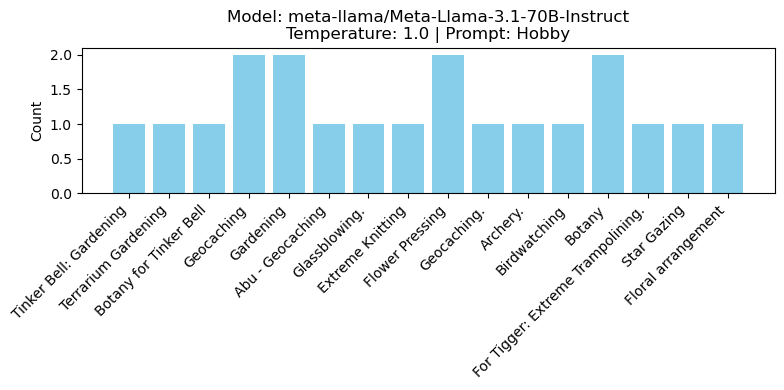

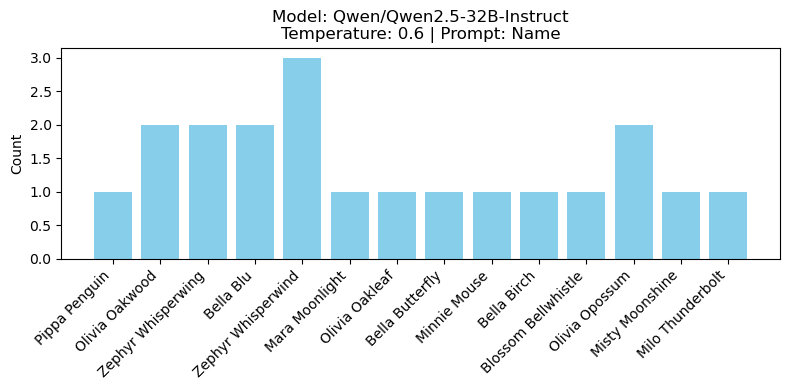

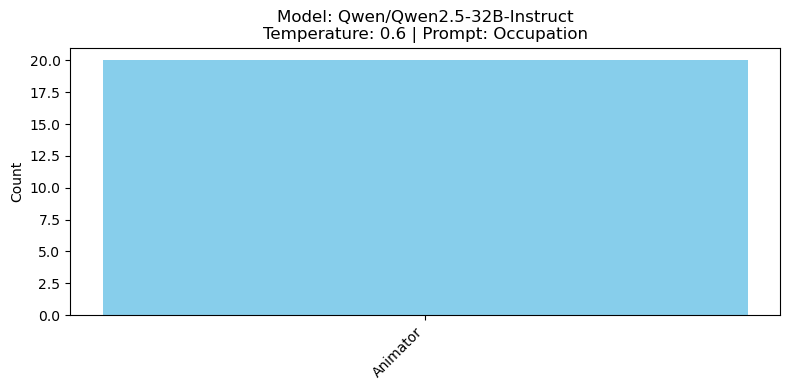

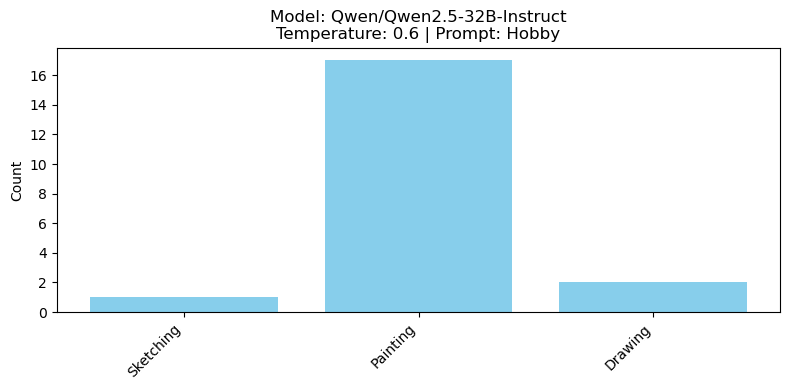

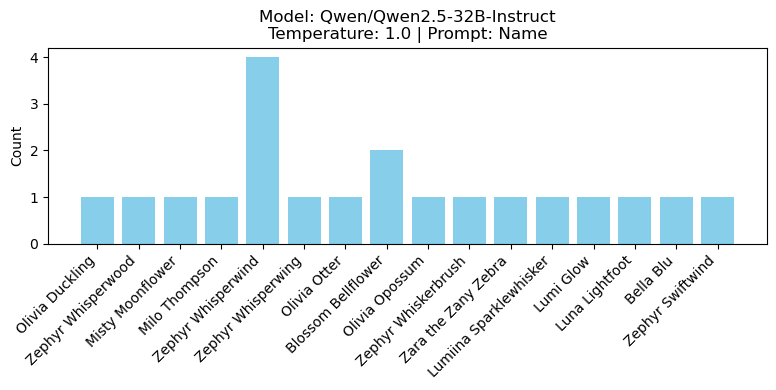

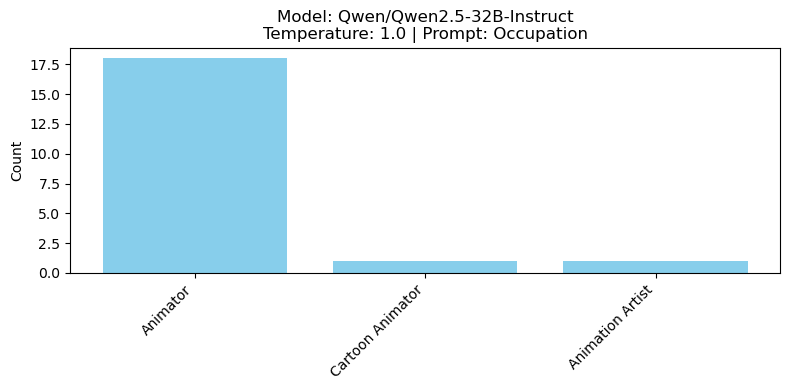

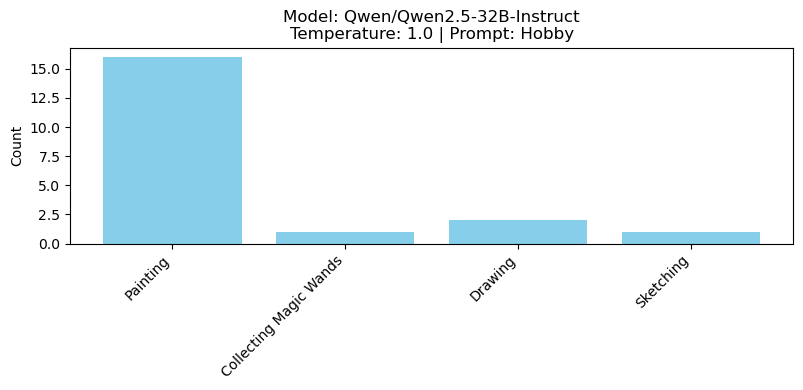

In [4]:
for model in all_results:
    for temp in all_results[model]:
        for prompt_type in all_results[model][temp]:
            responses = all_results[model][temp][prompt_type]
            counts = Counter(responses)
            
            # Prepare data for plotting
            labels = list(counts.keys())
            values = list(counts.values())

            # Create the bar plot
            plt.figure(figsize=(8, 4))
            bars = plt.bar(labels, values, color='skyblue')
            plt.title(f"Model: {model}\nTemperature: {temp} | Prompt: {prompt_type}")
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

In [34]:
'''
Function Prepares lists to collect the folowing data:

generated_tokens list: the tokens (words or parts of words) the LLM actually generated.
generated_logprobs: their log probabilities (how likely the model thought they were).

top_tokens and top_logprobs: lists to collect the top alternative tokens and their probabilities at each step, besides the generated one.

Fills the lists by:
For each generated token, it adds the token and its log probability.
Creates a pandas DataFrame and puts the generated tokens and logprobs into columns.
Adds extra columns for each of the top alternative tokens and their logprobs (e.g., 0_token, 0_logp, 1_token, 1_logp, etc.).
Returns the DataFrame for easy analysis or display.
'''
# ------ Logprobs Analysis ------
def logprobs_to_table(logprobs_content):
    generated_tokens = [] #store the actual tokens the LLM generated.
    generated_logprobs = [] #will store the log probability (a measure of "confidence") for each generated token.

    #Creates lists of empty lists to hold the alternative ("top") tokens and their log probabilities for each position in the sequence.
    # The list contains the select token which i already captured. I just want to collect and store the alternative ones. Hence I "-1"
    top_tokens = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]
    top_logprobs = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]

    '''
    Loops through each token position in the generated sequence.
    1-Adds the actual generated token and its log probability to their respective lists.
    2-For the alternative tokens at this position (entry.top_logprobs[1:]):\
    3-Adds each alternative token (top_logprob.token) to the appropriate sub-list in top_tokens.
    4-Adds the alternative's log probability (top_logprob.logprob) to the appropriate sub-list in top_logprobs.
    '''
    for entry in logprobs_content:
        generated_tokens.append(entry.token)
        generated_logprobs.append(entry.logprob)
        for j, top_logprob in enumerate(entry.top_logprobs[1:]):
            top_tokens[j].append(top_logprob.token)
            top_logprobs[j].append(top_logprob.logprob)
    
    import pandas as pd
    pd.set_option('display.max_columns', 20)     # Show up to 20 columns
    pd.set_option('display.width', 1000)         # Increase the width for wrapping
    pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping
    
    df = pd.DataFrame({
        "gen_token": generated_tokens,
        "gen_logp": generated_logprobs
    })
    for j in range(len(top_tokens)):
        df[f"{j}_token"] = top_tokens[j]
        df[f"{j}_logp"] = top_logprobs[j]
    return df

In [35]:
'''
Call function to analyze LLM model outputs for different prompts.
Loops through all your models and prompts:

For each model and each prompt type (like "name", "occupation", "hobby"):
Calls answer_with_logprobs() to get the model’s output with log probability info using temperature 0.6.
Process the output into a table using your function:

If successful, prints the DataFrame (so you can see which words/tokens were chosen and how likely they were).
If there’s an error (e.g., if logprob data isn’t present), prints an error message.
'''

print("\n==== Logprob Analysis (temperature=0.6) ====\n")

for model in llm_models:
    for prompt_type, prompt in prompts.items():
        logprob_completion = answer_with_logprobs(
            prompt=prompt,
            model=model,
            temperature=0.6
        )
        print(f"\nModel: {model} | Prompt: {prompt_type}")
        try:
            logprobs_df = logprobs_to_table(logprob_completion.choices[0].logprobs.content)
            print(logprobs_df)
        except Exception as e:
            print("Error processing logprobs:", e)


==== Logprob Analysis (temperature=0.6) ====



Luna Sparklesong

Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Prompt: Name
    gen_token  gen_logp     0_token    0_logp     1_token     1_logp   2_token     2_logp 3_token     3_logp
0           L -0.224553           F -2.615178           Z  -2.755803         B  -4.552678     Flo  -4.677678
1         una -1.073844          un -1.198844          um  -1.542594      umin  -2.558219     umi  -3.401969
2      ĠSpark -0.198230          fl -2.479480      ĠBloom  -4.213855  ĠFlutter  -4.870105      ĠF  -4.885730
3         les -0.669253          le -1.419253        span  -2.513003      wing  -3.091128      sw  -3.919253
4         ong -0.154949  <|eot_id|> -3.029949          on  -3.217449     worth  -4.600262    wing  -4.662762
5  <|eot_id|> -0.001188           . -6.876188  <|eom_id|> -10.376188         ! -10.704313       e -10.962126


Pirate Captain's First Mate

Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Prompt: Occupation
    gen_token

In [36]:
print("\n==== Logprob Analysis (temperature=1) ====\n")
for model in llm_models:
    for prompt_type, prompt in prompts.items():
        logprob_completion = answer_with_logprobs(
            prompt=prompt,
            model=model,
            temperature=1
        )
        print(f"\nModel: {model} | Prompt: {prompt_type}")
        try:
            logprobs_df = logprobs_to_table(logprob_completion.choices[0].logprobs.content)
            print(logprobs_df)
        except Exception as e:
            print("Error processing logprobs:", e)


==== Logprob Analysis (temperature=1) ====



Buzzina

Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Prompt: Name
    gen_token  gen_logp 0_token    0_logp 1_token    1_logp   2_token    2_logp 3_token    3_logp
0        Buzz -7.341740       L -0.224553       F -2.615178         Z -2.755803       B -4.552678
1         ina -0.130067      by -2.692567     ley -5.380067        le -5.387880     ine -6.044130
2  <|eot_id|> -3.309555  ĠSpark -0.887680  ĠBloom -1.700180  ĠFlutter -2.606430   ĠStar -2.614243


Deputy Underwater Explorer

Model: meta-llama/Meta-Llama-3.1-8B-Instruct | Prompt: Occupation
    gen_token  gen_logp   0_token    0_logp    1_token    1_logp  2_token    2_logp 3_token    3_logp
0          De -8.961169        To -2.547107        Lib -2.734607        P -2.765857  Master -2.789294
1        puty -0.750784        er -1.203909          b -1.813284       ej -4.680472    bate -4.789847
2      ĠUnder -6.757266  ĠSheriff -1.640079      ĠPark -2.343204  ĠForest -2.890079    ĠDo